In [36]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from matplotlib import gridspec


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [7]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [8]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [9]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [10]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [11]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [12]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [13]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


# Histogram N=2, M=1

In [84]:
#Parameter definition 
N= 2
M=1
B = 1
A0 = 1
M1gdResults = [] #gives ground state estimation at each iteration of gd
M1gdState = []
M1gdTime = []

M1edState = []
M1edTime = []

ActualEng = []
M1engErr = []
M1stateErr = []

hisIt = np.arange(100)

In [85]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    M1gdResults.append(gd)
    M1gdState.append(gd[0])
    M1gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    M1edState.append(ed[0])
    M1edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEng)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    M1engErr.append(errTemp[0])
    M1stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 42
         Function evaluations: 1080
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: -0.957101
         Iterations: 27
         Function evaluations: 732
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: -0.957098
         Iterations: 42
         Function evaluations: 1044
         Gradient evaluations: 87
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 42
         Function evaluations: 1008
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: -0.957106
         Iterations: 30
         Function evaluations: 720
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 23
         Function eval

Optimization terminated successfully.
         Current function value: -0.749958
         Iterations: 6
         Function evaluations: 228
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: -0.957091
         Iterations: 29
         Function evaluations: 972
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: -0.957104
         Iterations: 34
         Function evaluations: 852
         Gradient evaluations: 71
Optimization terminated successfully.
         Current function value: -0.957069
         Iterations: 28
         Function evaluations: 936
         Gradient evaluations: 78
Optimization terminated successfully.
         Current function value: -0.249989
         Iterations: 5
         Function evaluations: 288
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -0.957059
         Iterations: 25
         Function evaluatio

Optimization terminated successfully.
         Current function value: -0.957105
         Iterations: 50
         Function evaluations: 1176
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: -0.957103
         Iterations: 17
         Function evaluations: 612
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 22
         Function evaluations: 528
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: -0.957106
         Iterations: 33
         Function evaluations: 1152
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: -0.957104
         Iterations: 22
         Function evaluations: 660
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: -0.957043
         Iterations: 59
         Function evalu

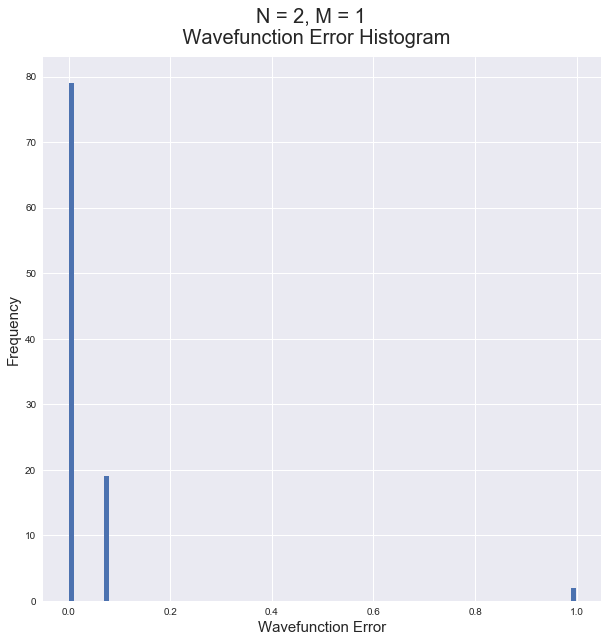

In [87]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1 \n Wavefunction Error Histogram",size =20)
ttl.set_position([.5, 0.95])
plt.hist(M1stateErr, bins=100) 
plt.xlabel("Wavefunction Error",size = 15)
plt.ylabel("Frequency", size = 15)
plt.show()

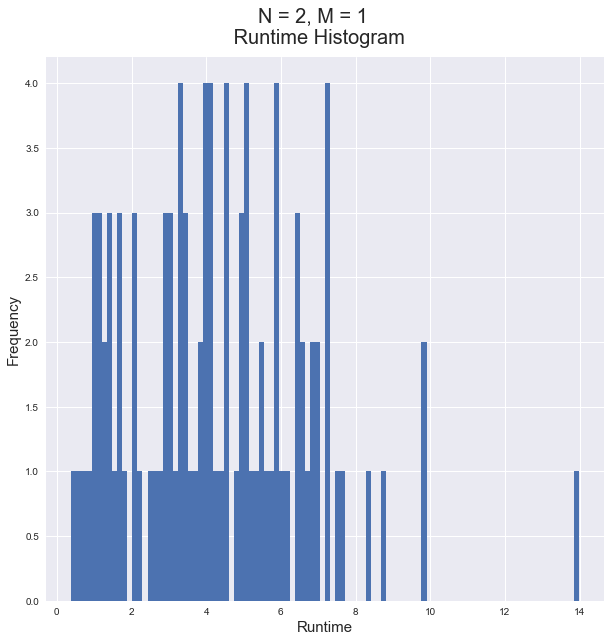

In [88]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1 \n Runtime Histogram",size =20)
ttl.set_position([.5, 0.95])
plt.hist(M1gdTime, bins=100) 
plt.xlabel("Runtime",size = 15)
plt.ylabel("Frequency", size = 15)
plt.show()

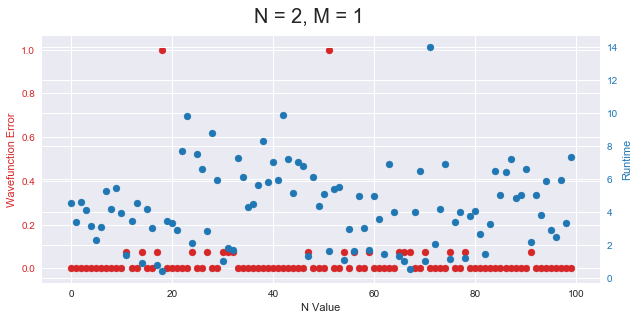

In [95]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1 ",size =20)
ttl.set_position([.5, 0.92])
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.scatter(hisIt, M1stateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Runtime', color=color)  
ax2.scatter(hisIt, M1gdTime, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Histogram N=2, M=2

In [90]:
#Parameter definition 
N= 2
M=2
B = 1
A0 = 1
M2gdResults = [] #gives ground state estimation at each iteration of gd
M2gdState = []
M2gdTime = []

M2edState = []
M2edTime = []

ActualEng = []
M2engErr = []
M2stateErr = []

M2hisIt = np.arange(100)

In [91]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    M2gdResults.append(gd)
    M2gdState.append(gd[0])
    M2gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    M2edState.append(ed[0])
    M2edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEng)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    M2engErr.append(errTemp[0])
    M2stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 18
         Function evaluations: 828
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -0.957097
         Iterations: 79
         Function evaluations: 3042
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: -0.957105
         Iterations: 24
         Function evaluations: 1206
         Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: -0.957100
         Iterations: 55
         Function evaluations: 2484
         Gradient evaluations: 138
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 15
         Function evaluations: 450
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 20
         Function ev

Optimization terminated successfully.
         Current function value: -0.957097
         Iterations: 33
         Function evaluations: 990
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 37
         Function evaluations: 1386
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 15
         Function evaluations: 666
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: -0.957106
         Iterations: 21
         Function evaluations: 882
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: -0.957101
         Iterations: 90
         Function evaluations: 2664
         Gradient evaluations: 148
Optimization terminated successfully.
         Current function value: -0.957104
         Iterations: 68
         Function eval

Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 15
         Function evaluations: 594
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 14
         Function evaluations: 522
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -0.750011
         Iterations: 4
         Function evaluations: 324
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 18
         Function evaluations: 738
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 22
         Function evaluations: 792
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 13
         Function evaluati

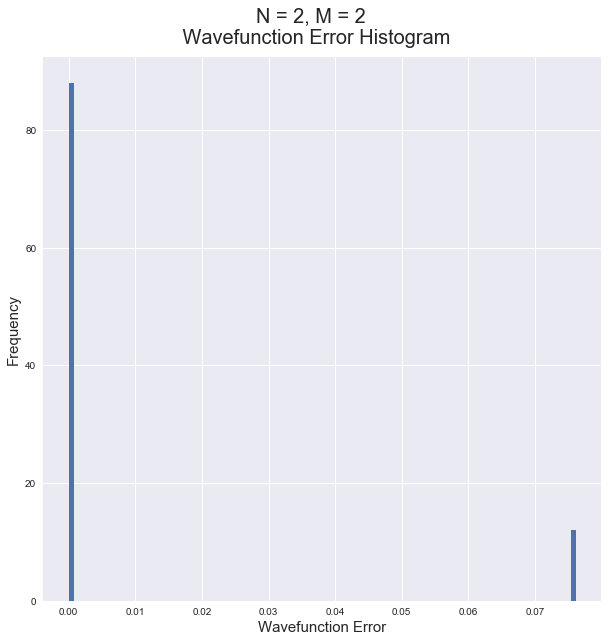

In [92]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 2 \n Wavefunction Error Histogram",size =20)
ttl.set_position([.5, 0.95])
plt.hist(M2stateErr, bins=100) 
plt.xlabel("Wavefunction Error",size = 15)
plt.ylabel("Frequency", size = 15)
plt.show()

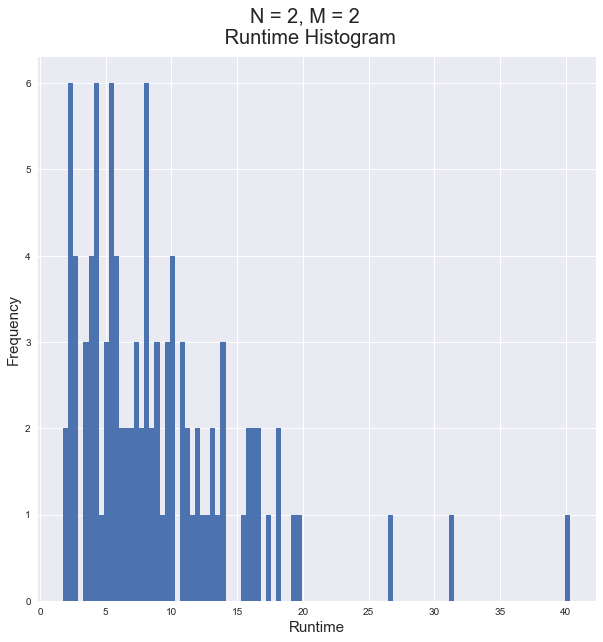

In [93]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 2 \n Runtime Histogram",size =20)
ttl.set_position([.5, 0.95])
plt.hist(M2gdTime, bins=100) 
plt.xlabel("Runtime",size = 15)
plt.ylabel("Frequency", size = 15)
plt.show()

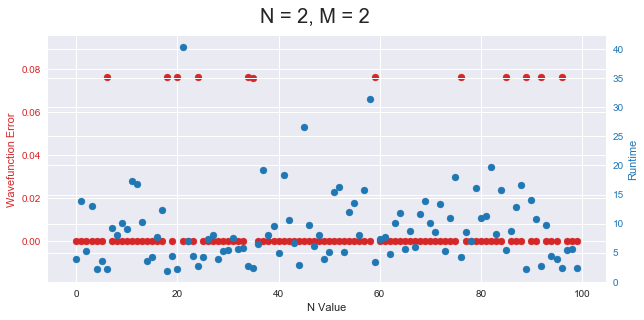

In [96]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 2 ",size =20)
ttl.set_position([.5, 0.92])
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.scatter(hisIt, M2stateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Runtime', color=color)  
ax2.scatter(hisIt, M2gdTime, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Histogram N=3, M=1

In [97]:
#Parameter definition 
N= 3
M=1
B = 1
A0 = 1
N3M1gdResults = [] #gives ground state estimation at each iteration of gd
N3M1gdState = []
N3M1gdTime = []

N3M1edState = []
N3M1edTime = []

ActualEng = []
N3M1engErr = []
N3M1stateErr = []

hisIt = np.arange(100)

In [ ]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    N3M1gdResults.append(gd)
    N3M1gdState.append(gd[0])
    N3M1gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    N3M1edState.append(ed[0])
    N3M1edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEng)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    N3M1engErr.append(errTemp[0])
    N3M1stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -1.280732
         Iterations: 190
         Function evaluations: 6880
         Gradient evaluations: 430
Optimization terminated successfully.
         Current function value: -1.280681
         Iterations: 223
         Function evaluations: 8848
         Gradient evaluations: 553
Optimization terminated successfully.
         Current function value: -0.999968
         Iterations: 7
         Function evaluations: 416
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -0.499975
         Iterations: 3
         Function evaluations: 240
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: -0.999918
         Iterations: 7
         Function evaluations: 416
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -0.999954
         Iterations: 7
         Function evalu

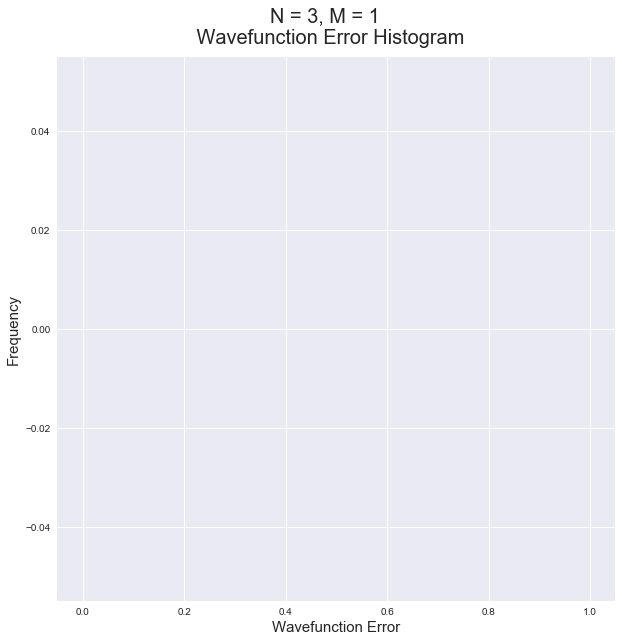

In [19]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 3, M = 1 \n Wavefunction Error Histogram",size =20)
ttl.set_position([.5, 0.95])
plt.hist(N3M2stateErr, bins=50) 
plt.xlabel("Wavefunction Error",size = 15)
plt.ylabel("Frequency", size = 15)
plt.show()

In [20]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 3, M = 1 \n Runtime Histogram",size =20)
ttl.set_position([.5, 0.95])
plt.hist(N3M1gdTime, bins=100) 
plt.xlabel("Runtime",size = 15)
plt.ylabel("Frequency", size = 15)
plt.show()

NameError: name 'N3M1gdTime' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 3, M = 1 ",size =20)
ttl.set_position([.5, 0.92])
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.scatter(hisIt, N3M1stateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Runtime', color=color)  
ax2.scatter(hisIt, N3M1gdTime, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Histogram N=3, M=2

In [14]:
#Parameter definition 
N= 3
M=2
B = 1
A0 = 1
N3M2gdResults = [] #gives ground state estimation at each iteration of gd
N3M2gdState = []
N3M2gdTime = []

N3M2edState = []
N3M2edTime = []

ActualEng = []
N3M2engErr = []
N3M2stateErr = []

hisIt = np.arange(50)

In [21]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    N3M2gdResults.append(gd)
    N3M2gdState.append(gd[0])
    N3M2gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    N3M2edState.append(ed[0])
    N3M2edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    N3M2engErr.append(errTemp[0])
    N3M2stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -1.280746
         Iterations: 1315
         Function evaluations: 62856
         Gradient evaluations: 2619
Optimization terminated successfully.
         Current function value: -0.999951
         Iterations: 9
         Function evaluations: 600
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: -1.280775
         Iterations: 98
         Function evaluations: 4248
         Gradient evaluations: 177
Optimization terminated successfully.
         Current function value: -1.280722
         Iterations: 192
         Function evaluations: 10992
         Gradient evaluations: 458
Optimization terminated successfully.
         Current function value: -1.280715
         Iterations: 246
         Function evaluations: 14400
         Gradient evaluations: 600
Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 5
         Fu

Optimization terminated successfully.
         Current function value: -1.280660
         Iterations: 196
         Function evaluations: 10848
         Gradient evaluations: 452
Optimization terminated successfully.
         Current function value: -1.280726
         Iterations: 301
         Function evaluations: 16008
         Gradient evaluations: 667
Optimization terminated successfully.
         Current function value: -1.280745
         Iterations: 214
         Function evaluations: 9672
         Gradient evaluations: 403


<Figure size 748.8x514.8 with 0 Axes>

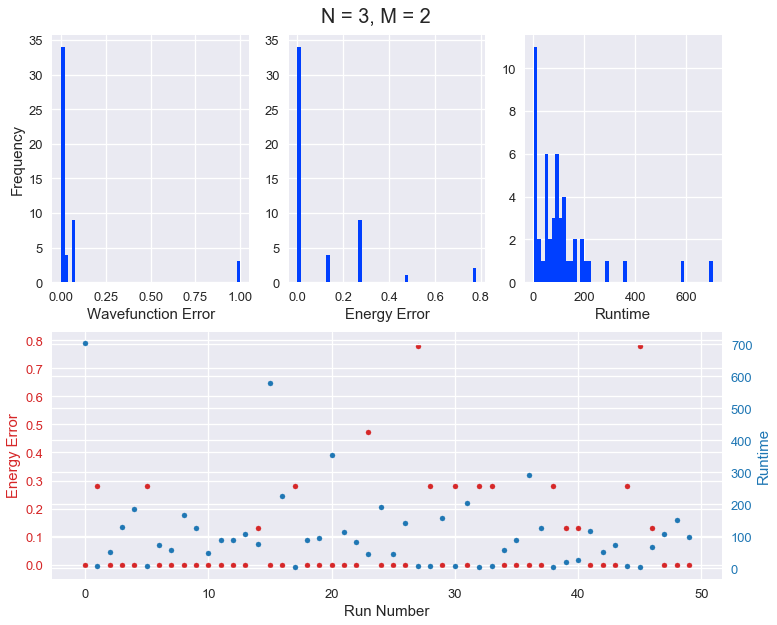

In [38]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 3, M = 2",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(N3M2stateErr, bins=50) 
ax1 .set_xlabel("Wavefunction Error",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
N3M2counts, N3M2bins, N3M2bars =ax2.hist(N3M2engErr, bins=50) 
ax2.set_xlabel("Energy Error",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(N3M2gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('Energy Error', color=color,size = 15)
ax4.scatter(hisIt, N3M2engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, N3M2gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [39]:
print(N3M2counts)
smallError = 0
for i in range(50):
    if N3M2bins[i]<0.1:
        cutOff=i
print(cutOff)

for i in range(cutOff):
    smallError += N3M2counts[i]
successPer = smallError
print(successPer)

[34.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  9.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
6
34.0
